In [1]:
from glob import glob
import warnings
warnings.filterwarnings("ignore")

import altair as alt
from altair import datum
import joblib
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import LabelBinarizer

In [2]:
alt.data_transformers.enable("json")
alt.renderers.enable("mimetype")

RendererRegistry.enable('mimetype')

In [3]:
bank_train = pd.read_csv("../data/splits/bank_train.csv")
bank_test = pd.read_csv("../data/splits/bank_test.csv")

In [4]:
bank_X_tr = bank_train.drop("y", axis=1)
bank_y_tr_pp = LabelBinarizer().fit_transform(bank_train[["y"]]).ravel()

bank_X_tt = bank_test.drop("y", axis=1)
bank_y_tt_pp = LabelBinarizer().fit_transform(bank_test[["y"]]).ravel()

## Melhores modelos

In [5]:
models = []

for m in glob("../models/*.pkl"):
    model = joblib.load(m)
    print("Estimator: ", model.estimator.named_steps["clf"].__class__.__name__)
    print("AUC do Melhor Estimador: ", model.best_score_)
    models += [model]

Estimator:  RandomForestClassifier
AUC do Melhor Estimador:  0.8019645238469977
Estimator:  LinearSVC
AUC do Melhor Estimador:  0.7811653704475812
Estimator:  LogisticRegression
AUC do Melhor Estimador:  0.7822885384944351
Estimator:  DecisionTreeClassifier
AUC do Melhor Estimador:  0.7915722081721515


## Roc Curve

In [6]:
roc_dfs = []

for m in glob("../models/*.pkl"):
    model = joblib.load(m)
    model_name = model.estimator.named_steps["clf"].__class__.__name__
    y_preds = cross_val_predict(model.best_estimator_, bank_X_tr, bank_y_tr_pp, cv = 5, method = "predict_proba" if model_name != "LinearSVC" else "decision_function")
    fpr, tpr, thresholds = roc_curve(y_true=bank_y_tr_pp, y_score=y_preds[:, 1] if model_name != "LinearSVC" else y_preds)
    auc_ = model.best_score_
    data_ = pd.DataFrame({"model": [model_name]*len(fpr), "fpr": fpr, "tpr": tpr, "thresholds": thresholds, "auc": [auc_]*len(fpr)})
    roc_dfs.append(data_)
    print(model_name)
    
roc_curves_df = pd.concat(roc_dfs)

RandomForestClassifier
LinearSVC
LogisticRegression
DecisionTreeClassifier


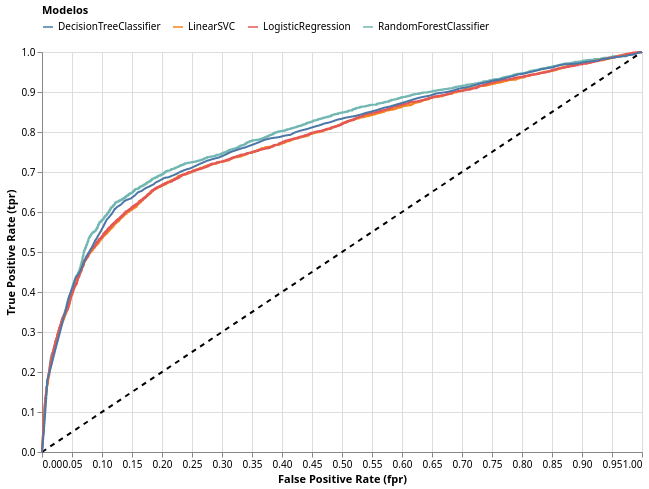

In [7]:
line = pd.DataFrame({"fpr": [0, 1], "tpr": [0, 1]})

base_plot = alt.Chart(line).mark_line(color="black", strokeDash=[5, 5]).encode(
    x=alt.X("fpr", title="False Positive Rate (fpr)"),
    y=alt.Y("tpr", title="True Positive Rate (tpr)")
)

roc_plot = alt.Chart(roc_curves_df).mark_line().encode(
    x="fpr:Q",
    y="tpr:Q",
    color=alt.Color("model:N", legend=alt.Legend(orient="top", title="Modelos")),
    tooltip=["model:N", "fpr:Q", "tpr:Q", "thresholds:Q", "auc:Q"]
)

(base_plot + roc_plot).properties(height=400, width=600)

## Precision Recall Curve

In [8]:
pr_rec_dfs = []

for m in glob("../models/*.pkl"):
    model = joblib.load(m)
    model_name = model.estimator.named_steps["clf"].__class__.__name__
    y_preds = cross_val_predict(model.best_estimator_, bank_X_tr, bank_y_tr_pp, cv = 5, method = "predict_proba" if model_name != "LinearSVC" else "decision_function")
    precision, recall, thresholds = precision_recall_curve(y_true=bank_y_tr_pp, probas_pred=y_preds[:, 1] if model_name != "LinearSVC" else y_preds)        
    data_ = pd.DataFrame({"model": [model_name]*len(thresholds), "recall": recall[:-1], "precision": precision[:-1], "thresholds": thresholds})
    pr_rec_dfs.append(data_)
    print(model_name)
    
pr_rec_df = pd.concat(pr_rec_dfs)

RandomForestClassifier
LinearSVC
LogisticRegression
DecisionTreeClassifier


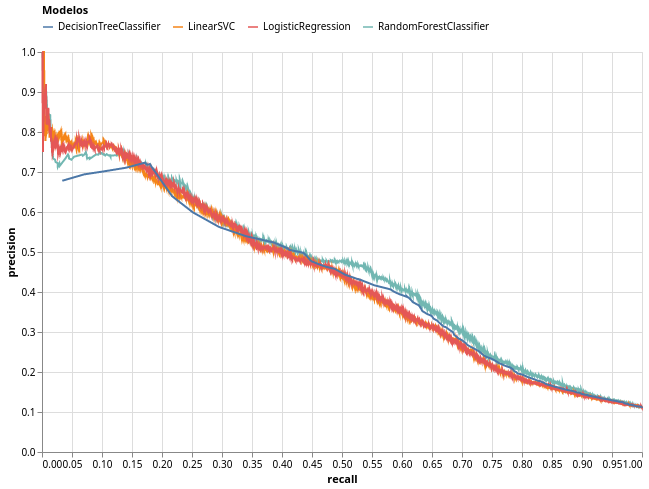

In [9]:
pr_rec_plot = alt.Chart(pr_rec_df).mark_line().encode(
    x="recall:Q",
    y="precision:Q",
    color=alt.Color("model:N", legend=alt.Legend(orient="top", title="Modelos")),
    tooltip=["model:N", "recall:Q", "precision:Q", "thresholds:Q"]
).properties(height=400, width=600)

pr_rec_plot

In [10]:
rf_model = joblib.load("../models/rf.pkl")

In [11]:
rf_model.best_estimator_.named_steps["transf_features"].named_transformers_["pca_econ_vars"].named_steps["pca"]

PCA(n_components=1)

In [12]:
col_names = [
    "age",
    "job",
    *rf_model.best_estimator_.named_steps["transf_features"].named_transformers_["oh_marital"].get_feature_names_out().tolist(),
    "education",
    "month",
    "day_of_week",
    *rf_model.best_estimator_.named_steps["transf_features"].named_transformers_["oh_default"].get_feature_names_out().tolist(),
    *rf_model.best_estimator_.named_steps["transf_features"].named_transformers_["oh_housing_loan_contact"].get_feature_names_out().tolist(),
    *rf_model.best_estimator_.named_steps["transf_features"].named_transformers_["bin_campaign"].get_feature_names_out().tolist(),
    *rf_model.best_estimator_.named_steps["transf_features"].named_transformers_["bin_previous"].get_feature_names_out().tolist(),
    "pca_econ_vars",
    *["cons.price.idx", "cons.conf.idx"]
]


In [13]:
feature_importances = pd.DataFrame({
    "feature": col_names,
    "importance": rf_model.best_estimator_.named_steps["clf"].feature_importances_
})

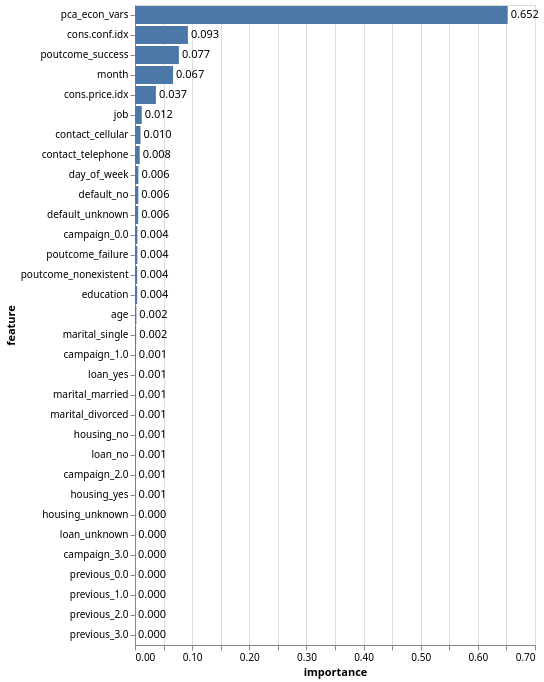

In [14]:
bars = alt.Chart(feature_importances).mark_bar().encode(
    x="importance:Q",
    y=alt.Y("feature", sort=alt.EncodingSortField("importance", op='min', order='descending'))
)

text = bars.mark_text(
    align="left",
    baseline="middle",
    dx=3,
).encode(
    text=alt.Text("importance:Q", format=".3f")
)

bars + text